<a href="https://colab.research.google.com/github/yoii18/KaggleModels/blob/main/Kaggle_PGS_S4E2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 4.5 MB/s eta 0:00:00


In [2]:
!pip install colorama

In [3]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


In [4]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.3 MB/s eta 0:00:00


In [5]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.1 MB/s eta 0:00:00


In [71]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
from itertools import combinations
import random
import gc

# Import sklearn classes for model selection, cross validation, and performance evaluation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, roc_curve
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
import seaborn as sns
from category_encoders import OneHotEncoder, CountEncoder, CatBoostEncoder
from imblearn.under_sampling import RandomUnderSampler

# Import libraries for Hypertuning
import optuna

# Import libraries for gradient boosting
import xgboost as xgb
import lightgbm as lgb
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import shap

In [7]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2', '#fee08b',
           '#66c2a5', '#5e4fa2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

plt.style.use('fivethirtyeight')

 We have the following features in our dataframes

 1. Gender
 2. Age
 3. Height
 4. Weight
 5. Frequent consumption of high caloric food (FAVC)
 6. Frequency of consumption of vegetables (FCVC)
 7. Number of main meals (NCP)
 8. Consumption of food between meals (CAEC)
 9. Consumption of water daily (CH20)
 10. Consumption of alcohol (CALC)
 11. Calories consumption monitoring (SCC)
 12. Physical activity frequency (FAF)
 13. Time using technology devices (TUE)
 14. Transportation used (MTRANS)
 15. family_history_with_overweight
 16. SMOKE

<b> Target Variable: </b><br>
NObesity values are:<br>
<li> Underweight Less than 18.5 </li>
<li>    Normal 18.5 to 24.9 </li>
<li>   Overweight 25.0 to 29.9 </li>
<li>    Obesity I 30.0 to 34.9 </li>
<li>    Obesity II 35.0 to 39.9 </li>
<li>    Obesity III Higher than 40 </li>

In [34]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E2/train.csv', index_col=[0])
test_data = pd.read_csv('/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E2/test.csv', index_col=[0])
original_data = pd.read_csv('/content/drive/MyDrive/Colab_Data/Kaggle_PGS_S4E2/ObesityDataSet.csv')

#train_data['is_generated'] = 1
#test_data['is_generated'] = 1
#original_data['is_generated'] = 0

original_data = original_data.reset_index()
original_data['id'] = original_data['index'] + test_data.index[-1] + 1
original_data = original_data.drop(columns = ['index']).set_index('id')

target = 'NObeyesdad'

In [9]:
train_data.head(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight


In [10]:
def stats(df):
  desc = df.describe().T.style.background_gradient()
  display(desc)
  #return desc

In [11]:
stats(train_data)

,count,mean,std,min,25%,50%,75%,max
Age,20758.000000,23.841804,5.688072,14.000000,20.000000,22.815416,26.000000,61.000000
Height,20758.000000,1.700245,0.087312,1.450000,1.631856,1.700000,1.762887,1.975663
Weight,20758.000000,87.887768,26.379443,39.000000,66.000000,84.064875,111.600553,165.057269
FCVC,20758.000000,2.445908,0.533218,1.000000,2.000000,2.393837,3.000000,3.000000
NCP,20758.000000,2.761332,0.705375,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,20758.000000,2.029418,0.608467,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.000000,0.981747,0.838302,0.000000,0.008013,1.000000,1.587406,3.000000
TUE,20758.000000,0.616756,0.602113,0.000000,0.000000,0.573887,1.000000,2.000000


In [12]:
stats_test = stats(test_data)

,count,mean,std,min,25%,50%,75%,max
Age,13840.000000,23.952740,5.799814,14.000000,20.000000,22.906342,26.000000,61.000000
Height,13840.000000,1.698934,0.088761,1.450000,1.631662,1.700000,1.760710,1.980000
Weight,13840.000000,87.384504,26.111819,39.000000,65.000000,83.952968,111.157811,165.057269
FCVC,13840.000000,2.442898,0.531606,1.000000,2.000000,2.358087,3.000000,3.000000
NCP,13840.000000,2.750610,0.710927,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,13840.000000,2.032044,0.611230,1.000000,1.771781,2.000000,2.552388,3.000000
FAF,13840.000000,0.974532,0.840361,0.000000,0.001086,1.000000,1.571865,3.000000
TUE,13840.000000,0.611033,0.608005,0.000000,0.000000,0.552498,1.000000,2.000000


In [13]:
stats_original = stats(original_data)

,count,mean,std,min,25%,50%,75%,max
Age,2111.000000,24.312600,6.345968,14.000000,19.947192,22.777890,26.000000,61.000000
Height,2111.000000,1.701677,0.093305,1.450000,1.630000,1.700499,1.768464,1.980000
Weight,2111.000000,86.586058,26.191172,39.000000,65.473343,83.000000,107.430682,173.000000
FCVC,2111.000000,2.419043,0.533927,1.000000,2.000000,2.385502,3.000000,3.000000
NCP,2111.000000,2.685628,0.778039,1.000000,2.658738,3.000000,3.000000,4.000000
CH2O,2111.000000,2.008011,0.612953,1.000000,1.584812,2.000000,2.477420,3.000000
FAF,2111.000000,1.010298,0.850592,0.000000,0.124505,1.000000,1.666678,3.000000
TUE,2111.000000,0.657866,0.608927,0.000000,0.000000,0.625350,1.000000,2.000000


In [15]:
def unique_vals(df, title=None):
  columns = train_data.columns[0:-1]
  for cols in columns:
    print(f"{title} values in {cols} is: ", df[cols].nunique())

def null_vals(df, title=None):
  columns = train_data.columns[0:-1]
  for cols in columns:
    print(f"{title} values in {cols} is: ", df[cols].isnull().sum())

def duplicate_vals(df, title=None):
  columns = train_data.columns[0:-1]
  for cols in columns:
    print(f"{title} values in {cols} is: ", df.shape[0] - df[cols].duplicated().sum())

In [16]:
unique_vals(train_data, "unique")

unique values in Gender is:  2
unique values in Age is:  1703
unique values in Height is:  1833
unique values in Weight is:  1979
unique values in family_history_with_overweight is:  2
unique values in FAVC is:  2
unique values in FCVC is:  934
unique values in NCP is:  689
unique values in CAEC is:  4
unique values in SMOKE is:  2
unique values in CH2O is:  1506
unique values in SCC is:  2
unique values in FAF is:  1360
unique values in TUE is:  1297
unique values in CALC is:  3
unique values in MTRANS is:  5


In [17]:
unique_vals(original_data, "unique")

unique values in Gender is:  2
unique values in Age is:  1402
unique values in Height is:  1574
unique values in Weight is:  1525
unique values in family_history_with_overweight is:  2
unique values in FAVC is:  2
unique values in FCVC is:  810
unique values in NCP is:  635
unique values in CAEC is:  4
unique values in SMOKE is:  2
unique values in CH2O is:  1268
unique values in SCC is:  2
unique values in FAF is:  1190
unique values in TUE is:  1129
unique values in CALC is:  4
unique values in MTRANS is:  5


In [18]:
null_vals(train_data, "null")

null values in Gender is:  0
null values in Age is:  0
null values in Height is:  0
null values in Weight is:  0
null values in family_history_with_overweight is:  0
null values in FAVC is:  0
null values in FCVC is:  0
null values in NCP is:  0
null values in CAEC is:  0
null values in SMOKE is:  0
null values in CH2O is:  0
null values in SCC is:  0
null values in FAF is:  0
null values in TUE is:  0
null values in CALC is:  0
null values in MTRANS is:  0


In [19]:
null_vals(original_data, "null")

null values in Gender is:  0
null values in Age is:  0
null values in Height is:  0
null values in Weight is:  0
null values in family_history_with_overweight is:  0
null values in FAVC is:  0
null values in FCVC is:  0
null values in NCP is:  0
null values in CAEC is:  0
null values in SMOKE is:  0
null values in CH2O is:  0
null values in SCC is:  0
null values in FAF is:  0
null values in TUE is:  0
null values in CALC is:  0
null values in MTRANS is:  0


In [20]:
duplicate_vals(train_data, "duplicate")

duplicate values in Gender is:  2
duplicate values in Age is:  1703
duplicate values in Height is:  1833
duplicate values in Weight is:  1979
duplicate values in family_history_with_overweight is:  2
duplicate values in FAVC is:  2
duplicate values in FCVC is:  934
duplicate values in NCP is:  689
duplicate values in CAEC is:  4
duplicate values in SMOKE is:  2
duplicate values in CH2O is:  1506
duplicate values in SCC is:  2
duplicate values in FAF is:  1360
duplicate values in TUE is:  1297
duplicate values in CALC is:  3
duplicate values in MTRANS is:  5


In [21]:
duplicate_vals(original_data, "duplicate")

duplicate values in Gender is:  2
duplicate values in Age is:  1402
duplicate values in Height is:  1574
duplicate values in Weight is:  1525
duplicate values in family_history_with_overweight is:  2
duplicate values in FAVC is:  2
duplicate values in FCVC is:  810
duplicate values in NCP is:  635
duplicate values in CAEC is:  4
duplicate values in SMOKE is:  2
duplicate values in CH2O is:  1268
duplicate values in SCC is:  2
duplicate values in FAF is:  1190
duplicate values in TUE is:  1129
duplicate values in CALC is:  4
duplicate values in MTRANS is:  5


In [107]:
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)
print("Original Data Shape: ", original_data.shape)

Train Data Shape:  (20758, 17)
Test Data Shape:  (13840, 16)
Original Data Shape:  (2111, 17)


<b>Important points to look at from above stats:</b>
<br>
1. On the surface, there are no null values in our dataset
2. But, We see that `FAF` and `TUE` have values 0 which is not possible (in my opinion) so we must treat them as null values and impute them with mean values, since both these features are continuous features.
3. We have quite a lot of duplicate values in Original Data, while they shouldn't matter much in our train dataset, since the difference in number of duplicates in train and number of observations in train is huge, I feel that original dataset is not good enough to use since most values are duplicates

# Data Encoding and Feature Engineering
In this section we will do the following:
1. Encode the dataset
    * We will do `OneHotEncoding` on all categorical features except our `target`
    * On `target` we will do Label Encoding

2. We will then do Adversarial Validation to see if our Train-Test data is iid or not


In [24]:
train_data.head(2)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.66995,yes,yes,2.0,2.983297,Sometimes,no,2.763573,no,0.0,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.00000,yes,yes,2.0,3.000000,Frequently,no,2.000000,no,1.0,1.000000,no,Automobile,Normal_Weight


In [26]:
cat_cols, num_cols = [], []
columns = train_data.columns.tolist()
threshold = 5
for col in columns:
  if train_data[col].nunique() <= threshold:
    cat_cols.append(col)
  else:
    num_cols.append(col)

In [67]:
categories = ['Normal_Weight',
              'Insufficient_Weight',
              'Overweight_Level_I',
              'Overweight_Level_II',
              'Obesity_Type_I',
              'Obesity_Type_II',
              'Obesity_Type_III']

In [73]:
ce_ohe = OneHotEncoder(cols=cat_cols)
train_encoded = ce_ohe.fit_transform(train_data, train_data[target])
test_encoded = ce_ohe.fit_transform(test_data)
#original_encoded = ce_ohe.fit_transform(original_data, original_data[target])

ce_le = LabelEncoder()
train_encoded[target] = ce_le.fit_transform(train_encoded[target])
#test_encoded_data = ce_oe.fit_transform(train_encoded, train_encoded[target])
#original_encoded[target] = ce_le.fit_transform(original_encoded[target])

In [100]:
def adversarial_validation(dataset_1 = train_encoded, dataset_2 = test_encoded, label = 'Train-Test'):

    adv_train = dataset_1.drop(target, axis = 1)
    adv_test = dataset_2.copy()

    adv_train['is_test'] = 0
    adv_test['is_test'] = 1

    adv = pd.concat([adv_train, adv_test], ignore_index = True)

    adv_shuffled = adv.sample(frac = 1)

    adv_X = adv_shuffled.drop('is_test', axis = 1)
    adv_y = adv_shuffled.is_test

    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    val_scores = []
    predictions = np.zeros(len(adv))

    for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):

        adv_lr = xgb.XGBClassifier(random_state = 42)
        adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])

        val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:,1]
        predictions[val_idx] = val_preds
        val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
        val_scores.append(val_score)

    fpr, tpr, _ = roc_curve(adv['is_test'], predictions)

    plt.figure(figsize = (4, 4))
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
    plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight = 'bold', size = 17)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    importance = adv_lr.feature_importances_  #(adv_shuffled, type='ShapValues')
    plt.barh(adv_X.columns.tolist(), importance)

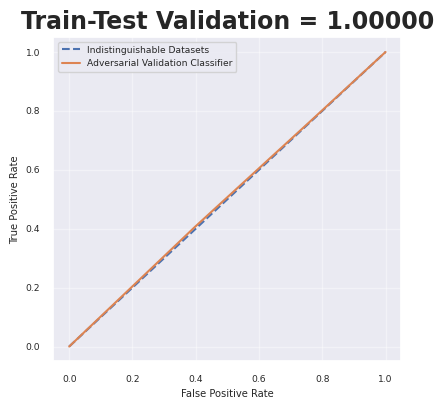

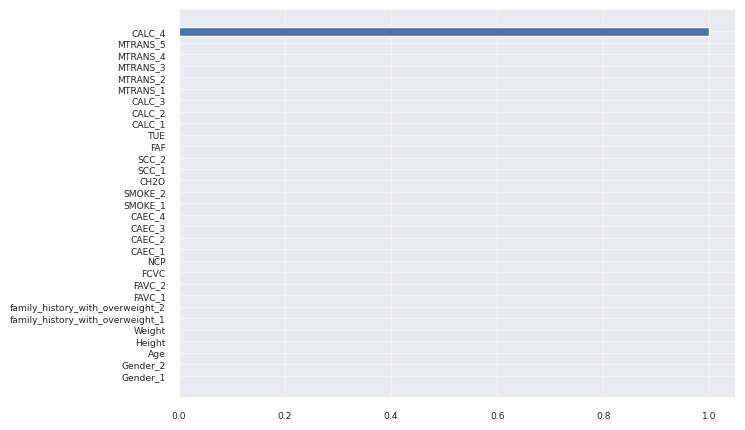

In [101]:
adversarial_validation()

In [103]:
test_encoded.drop('CALC_4', axis=1, inplace=True)
test_encoded.shape

(13840, 30)

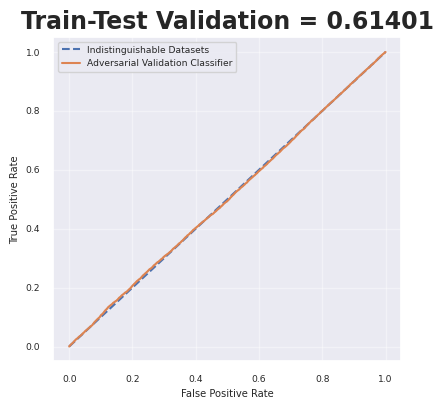

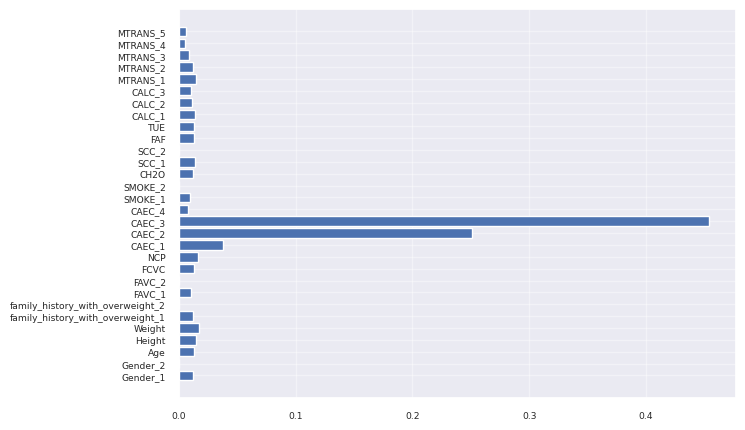

In [106]:
adversarial_validation()

<b>Analysis of Target Variable</b>

In [78]:
def target_var(df, title=None):
  fig, axes = plt.subplots(1,2,figsize=(9,3))
  sns.set(font_scale=0.6)
  df[target].value_counts().plot.pie(autopct='%1.1f%%',
                                    wedgeprops={'width': 0.5},
                                    startangle=0,
                                    ax=axes[0],
                                    shadow=False,
                                    textprops={'fontsize': 9},
                                    colors=palette)
  axes[0].set_ylabel('')
  sns.countplot(x=target, data=df, palette=palette)
  plt.suptitle(f"{title} - Target Variable Analysis")
  plt.tight_layout()
  plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



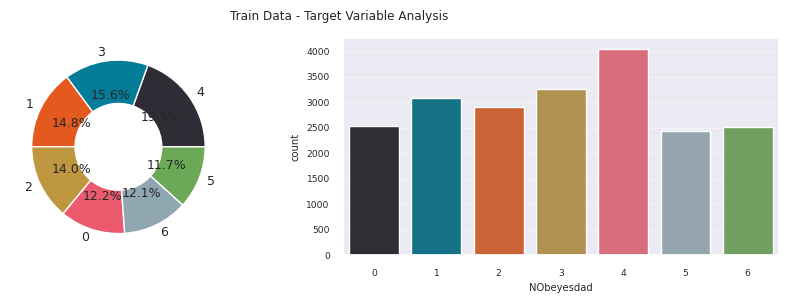

In [80]:
target_var(train_encoded, 'Train Data')